<a href="https://colab.research.google.com/github/JoeJiraWat/Ai-Builders/blob/main/Ai_files/Signal_Autotune_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




*   Data collection เก็บข้อมูลอะไรบ้างเพื่ออะไรเช่น Audio ที่ร้องเพลงถูกคีย์, Audio ของผู้ใช้งานที่มีโอกาสเกิดขึ้นจริง เช่น data audio จากเพื่อนและคนรู้จัก
*   ในกรณีที่ได้ datasets นี้มาจะทำให้รู้ว่า data เป็นยังไงมี Noise เยอะมั้ยถ้าผู้ใช้งานใช้จริง,
*   ถ้าพบว่า Noise เยอะ ต้องลองดูวิธีกรอง noise เช่น low pass filter frequency cut-off ที่ตรงไหน,
*  Background information: Prototype ของเราจะคัดแยกคีย์ประเภทอะไรบ้าง แต่ละคีย์มีลักษณะต่างกันยังไง สามารถสังเกตได้จากอะไรบ้างจุดนี้แนะนำให้ทำ Time domain และ fraqency domain เพื่อดูลักษณะของ Ampitude,
* Modeling แล้วจึงดูต่อไปเรื่องของการทำ Model อีกทีอาจจะเป็น model ที่เคยทำไปแล้วก็ได้ถ้ามันสามารถแก้ไขปัญหาได้จริง


In [184]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.decomposition import FastICA
import IPython
import IPython.display as ipd
from scipy.fft import fft, fftfreq, ifft, ifftshift
from scipy.signal import butter, lfilter, freqz

In [185]:
#load audio file
audio_file_path = '/content/drive/MyDrive/Datasets_For_Ai_builders/CleanVoice/Lady Gaga - Abracadabra (Lyrics)_vocal.wav'
sampling_rate = 10000
original_signal_y = np.array([])

In [186]:
try:
    original_signal_y, sampling_rate = librosa.load(audio_file_path, sr=None)
    print(f"Sampling Rate: {sampling_rate} Hz, จำนวน Samples: {len(original_signal_y)}")
    # ลดขนาดสัญญาณถ้ามันยาวเกินไป เพื่อให้ FFT และ filter ทำงานเร็วขึ้นสำหรับตัวอย่างนี้
    if len(original_signal_y) > sampling_rate * 10: # ถ้าสัญญาณยาวกว่า 10 วินาที
        original_signal_y = original_signal_y[:sampling_rate * 10]
        print(f"ตัดสัญญาณเหลือ {len(original_signal_y)/sampling_rate:.2f} วินาที เพื่อการประมวลผลที่เร็วขึ้น")
except Exception as e:
    #จะสร้างสัญญาณทดลอง (sine wave + noise) ขึ้นมาแทน
    sampling_rate = 44100
    duration = 2.0
    time_axis = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    signal_50hz = 0.7 * np.sin(2 * np.pi * 50 * time_axis)    # ความถี่ 50 Hz
    signal_500hz = 0.5 * np.sin(2 * np.pi * 500 * time_axis)  # ความถี่ 500 Hz
    signal_5000hz = 0.3 * np.sin(2 * np.pi * 5000 * time_axis) # ความถี่ 5000 Hz
    noise = 0.2 * np.random.randn(len(time_axis))
    original_signal_y = signal_50hz + signal_500hz + signal_5000hz + noise
    print(f"Sampling Rate: {sampling_rate} Hz, จำนวน Samples: {len(original_signal_y)}")

if len(original_signal_y) == 0:
    print("No Signal")
    exit()

Sampling Rate: 44100 Hz, จำนวน Samples: 9755802
ตัดสัญญาณเหลือ 10.00 วินาที เพื่อการประมวลผลที่เร็วขึ้น


ฟังก์ชันสำหรับคำนวณและเตรียมข้อมูล FFT สำหรับพล็อต

In [187]:
def get_fft_plot_data(signal, sr):
    N = len(signal)
    if N == 0:
        return np.array([]), np.array([])

    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1 / sr)

    # เอาเฉพาะส่วนความถี่บวก และคำนวณ magnitude
    # เราจะ plot แค่ครึ่งเดียวของ spectrum เพราะมันสมมาตร
    positive_freq_indices = np.where(xf >= 0)
    xf_positive = xf[positive_freq_indices]
    yf_magnitude_positive = np.abs(yf[positive_freq_indices])

    return xf_positive, yf_magnitude_positive


คำนวณ FFT ของสัญญาณต้นฉบับ

In [188]:
xf_original, yf_mag_original = get_fft_plot_data(original_signal_y, sampling_rate)


Low-pass Butterworth Filter

In [189]:
cutoff_freq = 2000  # Hz (ความถี่ที่จะเริ่มตัดออก, สัญญาณความถี่สูงกว่านี้จะถูกลดทอน)
filter_order = 5    # Order ของฟิลเตอร์ (ยิ่งสูง ยิ่งชัน แต่ก็อาจมีปัญหา phase shift มากขึ้น)

# Nyquist frequency (ความถี่สูงสุดที่เราสามารถแทนได้ คือครึ่งหนึ่งของ sampling rate)
nyq = 0.5 * sampling_rate

In [190]:
if cutoff_freq >= nyq:
    print(f" Cutoff frequency ({cutoff_freq} Hz) สูงหรือเท่ากับ Nyquist frequency ({nyq} Hz).")
    # ในกรณีนี้ เราอาจจะไม่ฟิลเตอร์ หรือใช้สัญญาณเดิมไปเลย
    filtered_signal_y = original_signal_y # หรือจัดการอย่างอื่นตามความเหมาะสม
else:
    normal_cutoff = cutoff_freq / nyq # ทำให้ cutoff frequency เป็นค่า normalized (0 ถึง 1)

    # b, a คือ coefficients ของฟิลเตอร์ ( числитель และ знаменатель ของ transfer function)
    # สำหรับ IIR filters เช่น Butterworth
    b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)

    # --- 4. นำฟิลเตอร์ไปใช้กับสัญญาณต้นฉบับ ---
    # lfilter ใช้ b, a coefficients เพื่อฟิลเตอร์สัญญาณ
    filtered_signal_y = lfilter(b, a, original_signal_y)


คำนวณ FFT ของสัญญาณที่ผ่านฟิลเตอร์

In [191]:
xf_filtered, yf_mag_filtered = get_fft_plot_data(filtered_signal_y, sampling_rate)


plot graph

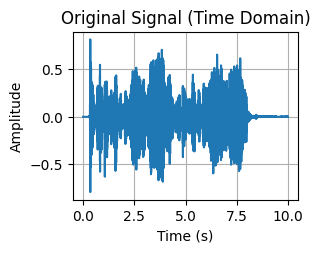

In [192]:
# กราฟที่ 1: สัญญาณต้นฉบับในโดเมนเวลา
plt.subplot(2, 2, 1) # (2 แถว, 2 คอลัมน์, vị tríที่ 1)
time_axis_original = np.linspace(0, len(original_signal_y) / sampling_rate, num=len(original_signal_y))
plt.plot(time_axis_original, original_signal_y)
plt.title('Original Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

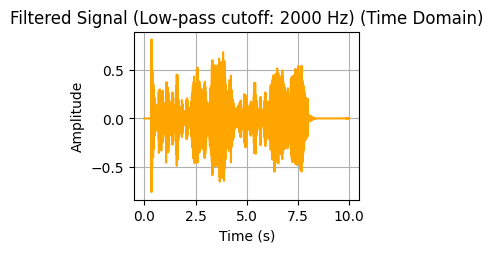

In [193]:
# กราฟที่ 2: สัญญาณที่ผ่านฟิลเตอร์ในโดเมนเวลา
plt.subplot(2, 2, 2)
time_axis_filtered = np.linspace(0, len(filtered_signal_y) / sampling_rate, num=len(filtered_signal_y))
plt.plot(time_axis_filtered, filtered_signal_y, color='orange')
plt.title(f'Filtered Signal (Low-pass cutoff: {cutoff_freq} Hz) (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

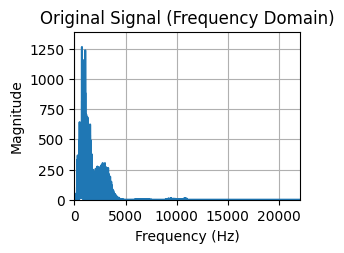

In [194]:
# กราฟที่ 3: สเปกตรัมความถี่ของสัญญาณต้นฉบับ
plt.subplot(2, 2, 3)
if len(xf_original) > 0:
    plt.plot(xf_original, yf_mag_original)
    plt.title('Original Signal (Frequency Domain)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, sampling_rate / 2) # แสดงถึง Nyquist frequency
    plt.ylim(0, np.max(yf_mag_original) * 1.1 if len(yf_mag_original) > 0 else 1) # ปรับแกน Y
    plt.grid(True)

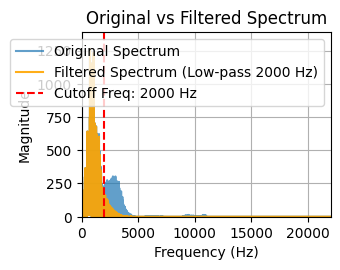

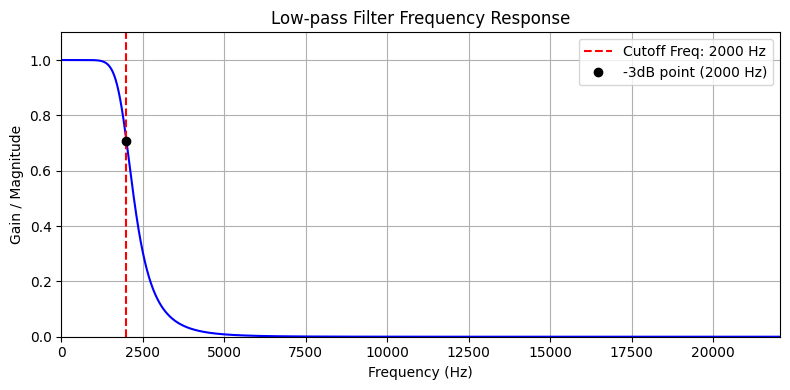

In [195]:
# กราฟที่ 4: สเปกตรัมความถี่ของสัญญาณต้นฉบับ และ สัญญาณที่ผ่านฟิลเตอร์ (ซ้อนกัน)
plt.subplot(2, 2, 4)
if len(xf_original) > 0:
    plt.plot(xf_original, yf_mag_original, label='Original Spectrum', alpha=0.7)
if len(xf_filtered) > 0:
    plt.plot(xf_filtered, yf_mag_filtered, label=f'Filtered Spectrum (Low-pass {cutoff_freq} Hz)', color='orange', alpha=0.9)
plt.title('Original vs Filtered Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, sampling_rate / 2) # แสดงถึง Nyquist frequency
# ปรับแกน Y ให้เห็นทั้งสอง spectrum
max_mag = 0
if len(yf_mag_original) > 0: max_mag = max(max_mag, np.max(yf_mag_original))
if len(yf_mag_filtered) > 0: max_mag = max(max_mag, np.max(yf_mag_filtered))
plt.ylim(0, max_mag * 1.1 if max_mag > 0 else 1)

plt.axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff Freq: {cutoff_freq} Hz') # เส้นแสดง cutoff freq
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# (เสริม) พล็อต Frequency Response ของฟิลเตอร์เอง (ถ้าต้องการดู)
if 'b' in locals() and 'a' in locals() and cutoff_freq < nyq: # ตรวจสอบว่า b, a ถูกสร้างหรือยัง
    w, h = freqz(b, a, worN=8000, fs=sampling_rate) # worN คือจำนวนจุดความถี่ที่จะคำนวณ
    plt.figure(figsize=(8,4))
    plt.plot(w, np.abs(h), 'b')
    plt.axvline(cutoff_freq, color='r', linestyle='--', label=f'Cutoff Freq: {cutoff_freq} Hz')
    plt.plot(cutoff_freq, 0.5*np.sqrt(2), 'ko', label=f'-3dB point ({cutoff_freq} Hz)') # จุด -3dB
    plt.title("Low-pass Filter Frequency Response")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain / Magnitude')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, sampling_rate/2)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

In [196]:
from scipy.signal import butter, lfilter, freqz

In [197]:
# เพื่อให้เห็นผลของฟิลเตอร์ชัดเจน สร้างสัญญาณที่มีหลายความถี่
sampling_rate = 44100
duration = 2.0
time_axis = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

freq1 = 50      # Hz
freq2 = 500     # Hz
freq3 = 2000    # Hz
freq4 = 8000    # Hz

signal_f1 = 1.0 * np.sin(2 * np.pi * freq1 * time_axis)
signal_f2 = 0.8 * np.sin(2 * np.pi * freq2 * time_axis)
signal_f3 = 0.6 * np.sin(2 * np.pi * freq3 * time_axis)
signal_f4 = 0.4 * np.sin(2 * np.pi * freq4 * time_axis)
noise = 0.1 * np.random.randn(len(time_axis))

original_signal_y = signal_f1 + signal_f2 + signal_f3 + signal_f4 + noise
print(f"Sampling Rate: {sampling_rate} Hz, จำนวน Samples: {len(original_signal_y)}")
print(f"ยความถี่: {freq1} Hz, {freq2} Hz, {freq3} Hz, {freq4} Hz และ noise")

Sampling Rate: 44100 Hz, จำนวน Samples: 88200
ยความถี่: 50 Hz, 500 Hz, 2000 Hz, 8000 Hz และ noise


In [198]:
# --- ฟังก์ชันสำหรับคำนวณและเตรียมข้อมูล FFT สำหรับพล็อต ---
def get_fft_plot_data(signal, sr):
    N = len(signal)
    if N == 0:
        return np.array([]), np.array([])
    yf = np.fft.fft(signal)
    xf = np.fft.fftfreq(N, 1 / sr)
    positive_freq_indices = np.where(xf >= 0)
    xf_positive = xf[positive_freq_indices]
    yf_magnitude_positive = np.abs(yf[positive_freq_indices])
    return xf_positive, yf_magnitude_positive


In [199]:
# --- ฟังก์ชันสำหรับออกแบบ, ใช้, และพล็อตฟิลเตอร์ ---
def apply_and_plot_filter(signal_in, sr, filter_type, cutoff_freqs, order, filter_name):
    nyq = 0.5 * sr

    # จัดการ cutoff_freqs สำหรับฟิลเตอร์แต่ละประเภท
    if filter_type == 'lowpass' or filter_type == 'highpass':
        if not isinstance(cutoff_freqs, (int, float)):
            print(f"Error: {filter_name} ต้องการ cutoff_freqs เป็นตัวเลขเดี่ยว")
            return
        if cutoff_freqs >= nyq:
            print(f"Warning: Cutoff frequency ({cutoff_freqs} Hz) สำหรับ {filter_name} สูงหรือเท่ากับ Nyquist ({nyq} Hz).")
            # อาจจะไม่ฟิลเตอร์ หรือคืนสัญญาณเดิม
            filtered_signal = signal_in
            b, a = np.array([1]), np.array([1]) # Dummy coefficients
        else:
            normal_cutoff = cutoff_freqs / nyq
            b, a = butter(order, normal_cutoff, btype=filter_type, analog=False)
            filtered_signal = lfilter(b, a, signal_in)
    elif filter_type == 'bandpass' or filter_type == 'bandstop':
        if not isinstance(cutoff_freqs, (list, tuple)) or len(cutoff_freqs) != 2:
            print(f"Error: {filter_name} ต้องการ cutoff_freqs เป็น list หรือ tuple ที่มี 2 ค่า (low, high)")
            return
        lowcut, highcut = cutoff_freqs
        if lowcut >= highcut:
            print(f"Error: Low cutoff ({lowcut}) ต้องน้อยกว่า High cutoff ({highcut}) สำหรับ {filter_name}")
            return
        if highcut >= nyq:
             print(f"Warning: High cutoff frequency ({highcut} Hz) สำหรับ {filter_name} สูงหรือเท่ากับ Nyquist ({nyq} Hz). ปรับค่า highcut.")
             highcut = nyq * 0.99 # ปรับเล็กน้อย
        if lowcut <= 0:
             print(f"Warning: Low cutoff frequency ({lowcut} Hz) สำหรับ {filter_name} ต่ำหรือเท่ากับ 0. ปรับค่า lowcut.")
             lowcut = 1 # ปรับเล็กน้อย

        normal_low = lowcut / nyq
        normal_high = highcut / nyq
        if normal_low >= normal_high: # Double check after normalization
            print(f"Error: Normalized low cutoff ({normal_low}) >= high cutoff ({normal_high}) for {filter_name}")
            return
        b, a = butter(order, [normal_low, normal_high], btype=filter_type, analog=False)
        filtered_signal = lfilter(b, a, signal_in)
    else:
        print(f"Error: ไม่รู้จัก filter_type: {filter_type}")
        return

    # เตรียมข้อมูล FFT
    xf_orig, yf_mag_orig = get_fft_plot_data(signal_in, sr)
    xf_filt, yf_mag_filt = get_fft_plot_data(filtered_signal, sr)

    # พล็อตกราฟ
    plt.figure(figsize=(15, 12))
    figure_title = f"Filter Type: {filter_name} | Cutoff(s): {cutoff_freqs} Hz | Order: {order}"
    plt.suptitle(figure_title, fontsize=16)

    # 1. Time domain: Original
    plt.subplot(3, 1, 1)
    time_ax = np.linspace(0, len(signal_in) / sr, num=len(signal_in))
    plt.plot(time_ax, signal_in, label='Original Signal', alpha=0.7)
    plt.plot(time_ax, filtered_signal, label=f'Filtered Signal ({filter_name})', color='orange', alpha=0.9)
    plt.title('Time Domain: Original vs Filtered')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 0.1) # ซูมดูช่วงสั้นๆ เพื่อให้เห็น waveform ชัดขึ้น

    # 2. Frequency domain: Original vs Filtered Spectrum
    plt.subplot(3, 1, 2)
    if len(xf_orig) > 0:
        plt.plot(xf_orig, yf_mag_orig, label='Original Spectrum', alpha=0.7)
    if len(xf_filt) > 0:
        plt.plot(xf_filt, yf_mag_filt, label=f'Filtered Spectrum ({filter_name})', color='orange', alpha=0.9)

    # วาดเส้น Cutoff
    if isinstance(cutoff_freqs, (int, float)):
        plt.axvline(cutoff_freqs, color='r', linestyle='--', label=f'Cutoff: {cutoff_freqs} Hz')
    elif isinstance(cutoff_freqs, (list, tuple)) and len(cutoff_freqs) == 2:
        plt.axvline(cutoff_freqs[0], color='r', linestyle='--', label=f'Low Cut: {cutoff_freqs[0]} Hz')
        plt.axvline(cutoff_freqs[1], color='m', linestyle='--', label=f'High Cut: {cutoff_freqs[1]} Hz')

    plt.title('Frequency Domain: Original vs Filtered Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, sr / 2)
    max_mag_display = 0
    if len(yf_mag_orig) > 0: max_mag_display = max(max_mag_display, np.max(yf_mag_orig))
    if len(yf_mag_filt) > 0: max_mag_display = max(max_mag_display, np.max(yf_mag_filt))
    plt.ylim(0, max_mag_display * 1.1 if max_mag_display > 0 else 1)
    plt.legend()
    plt.grid(True)

    # 3. Filter Frequency Response
    plt.subplot(3, 1, 3)
    w, h = freqz(b, a, worN=8000, fs=sr)
    plt.plot(w, np.abs(h), 'g')
    if isinstance(cutoff_freqs, (int, float)):
        plt.axvline(cutoff_freqs, color='r', linestyle='--', label=f'Cutoff: {cutoff_freqs} Hz')
        if cutoff_freqs < nyq : plt.plot(cutoff_freqs, 0.5*np.sqrt(2), 'ko', label='-3dB point')
    elif isinstance(cutoff_freqs, (list, tuple)) and len(cutoff_freqs) == 2:
        plt.axvline(cutoff_freqs[0], color='r', linestyle='--', label=f'Low Cut: {cutoff_freqs[0]} Hz')
        plt.axvline(cutoff_freqs[1], color='m', linestyle='--', label=f'High Cut: {cutoff_freqs[1]} Hz')
        if cutoff_freqs[0] > 0 and cutoff_freqs[0] < nyq: plt.plot(cutoff_freqs[0], 0.5*np.sqrt(2), 'ko')
        if cutoff_freqs[1] > 0 and cutoff_freqs[1] < nyq: plt.plot(cutoff_freqs[1], 0.5*np.sqrt(2), 'ko')


    plt.title(f"{filter_name} Frequency Response")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain / Magnitude')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, sr/2)
    plt.ylim(0, 1.1)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

In [200]:
filter_order = 5

In [201]:
#ปรับsampling rate
sampling_rate = 10000

สัญญาณ 50Hz และ 500Hz จะถูกลดทอน, 2000Hz และ 8000Hz ควรจะยังอยู่

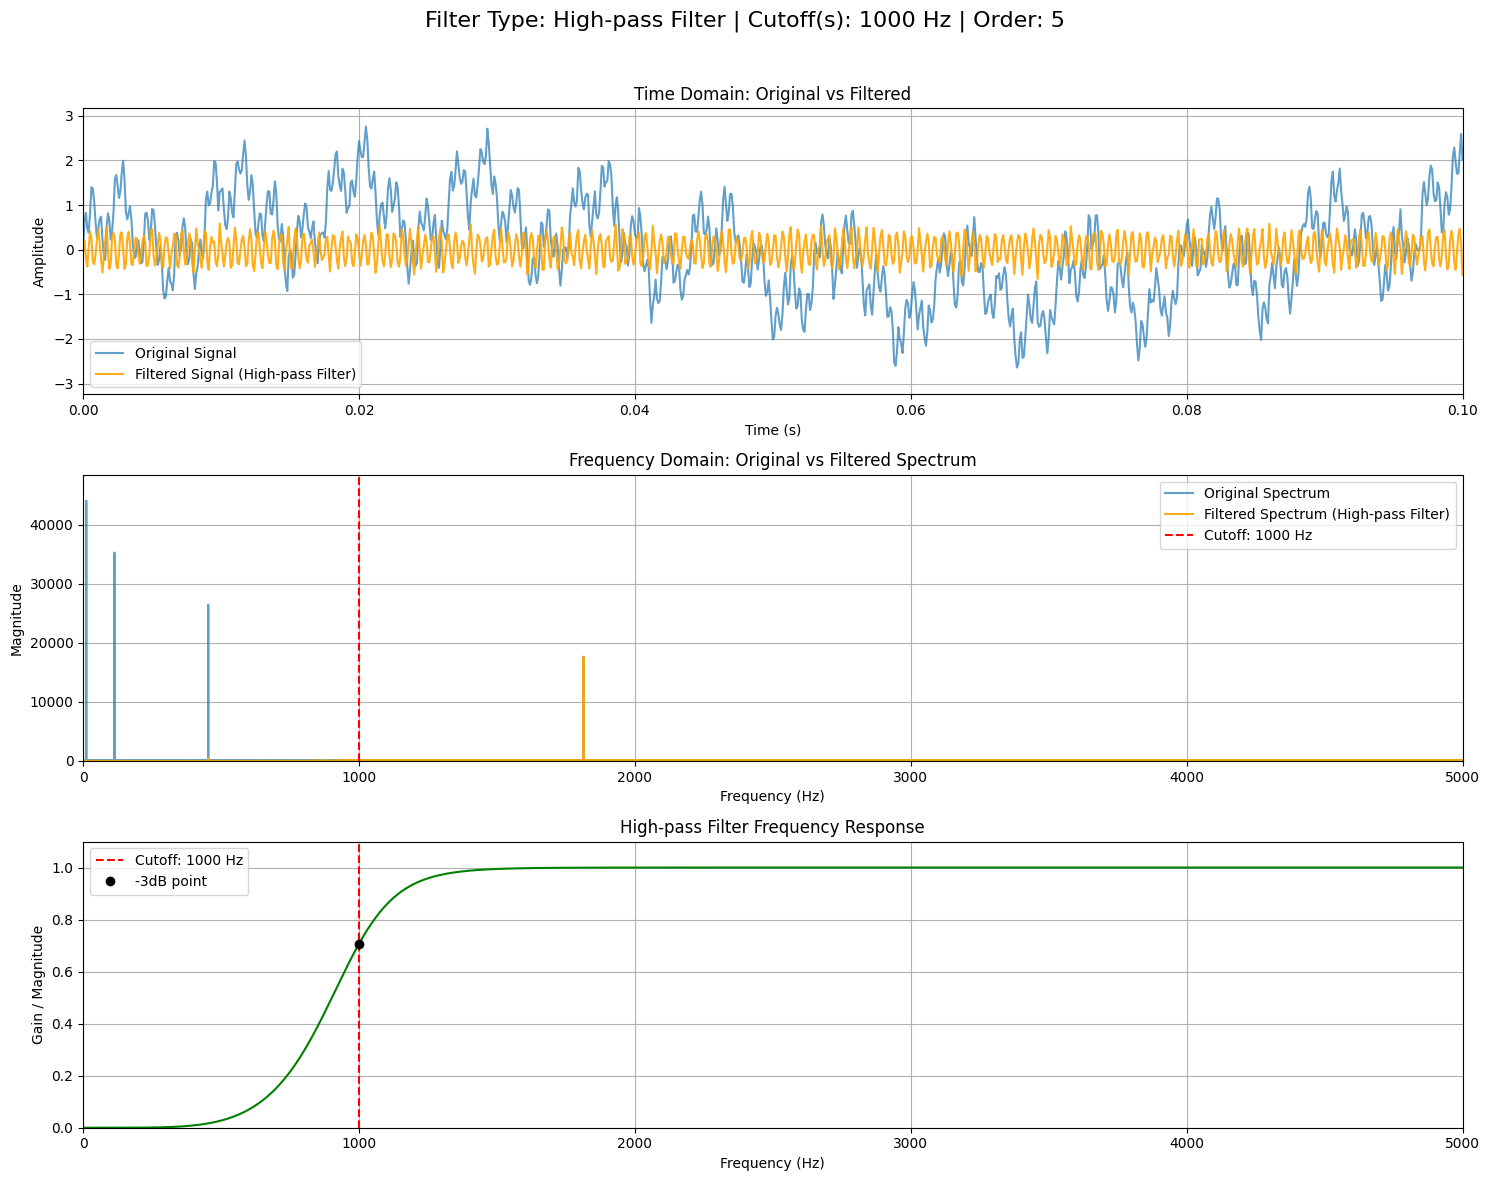

In [202]:
# 1. High-pass Filter
hp_cutoff = 1000 # Hz (จะตัดความถี่ต่ำกว่า 1000 Hz ออก)
apply_and_plot_filter(original_signal_y, sampling_rate, 'highpass', hp_cutoff, filter_order, "High-pass Filter")

สัญญาณ 500Hz จะยังอยู่, ความถี่อื่นๆ (50, 2000, 8000Hz) จะถูกลดทอน

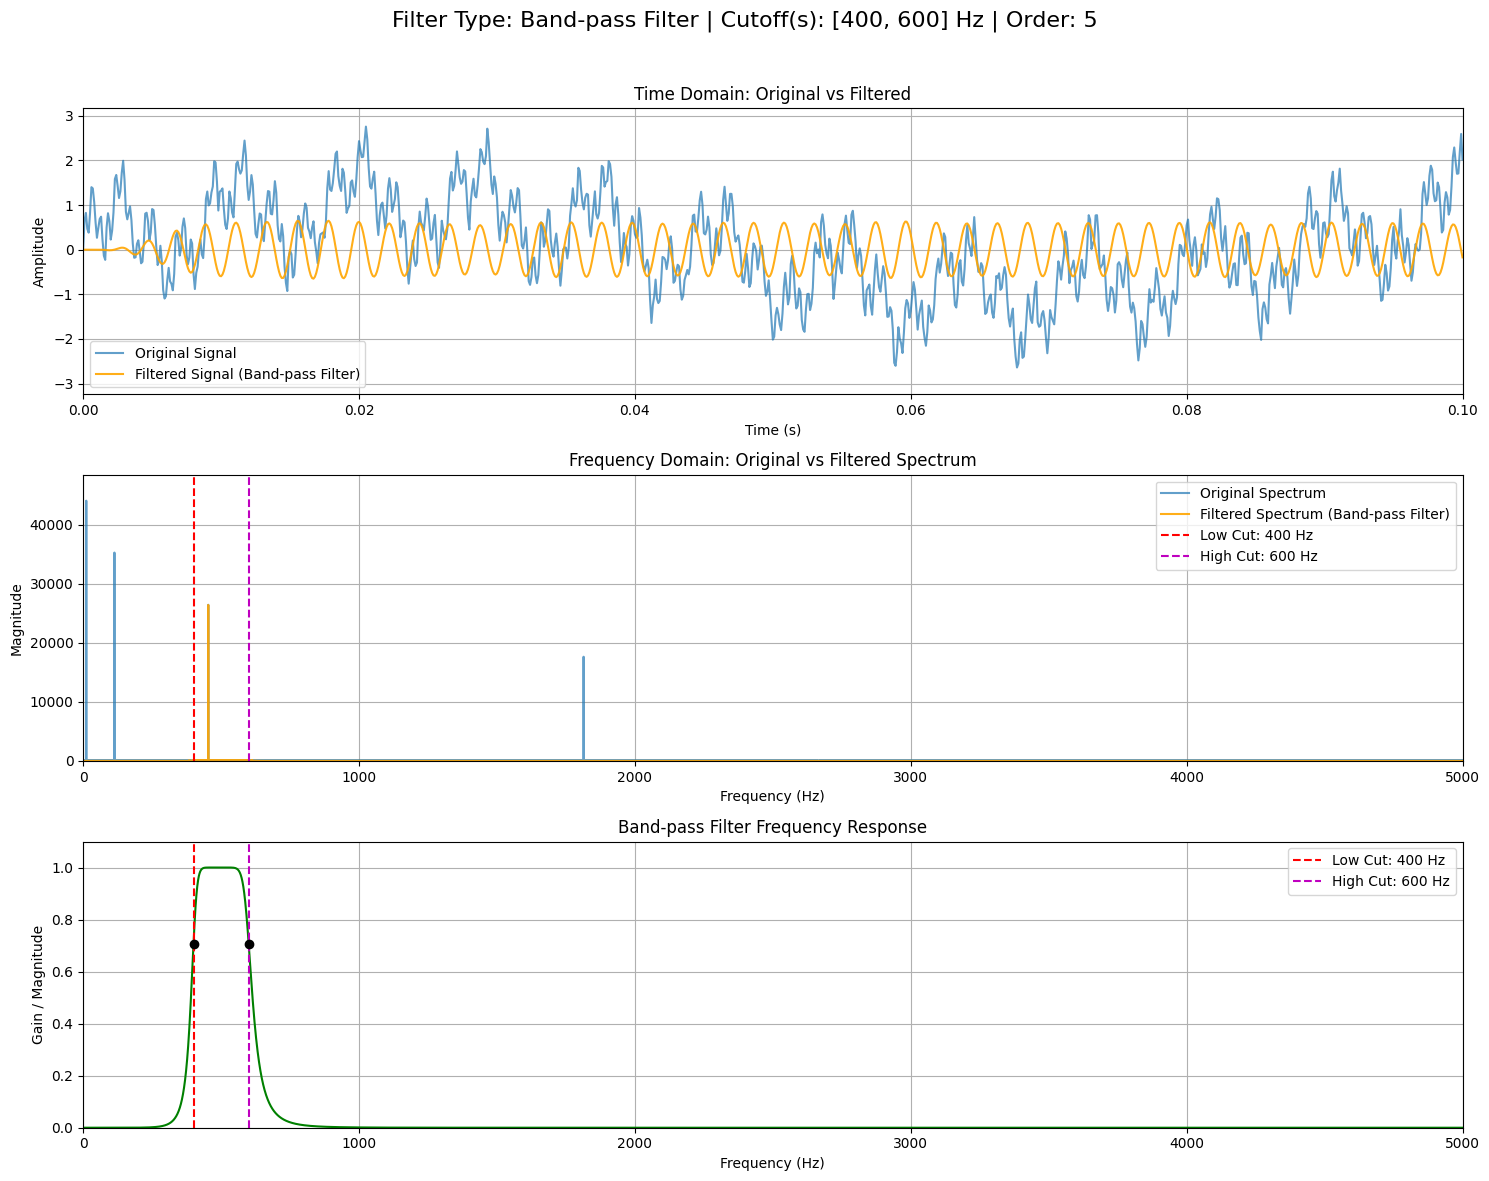

In [203]:
# 2. Band-pass Filter
bp_cutoffs = [400, 600] # Hz (จะปล่อยให้ความถี่ระหว่าง 400-600 Hz ผ่าน, คือเน้น 500Hz)
apply_and_plot_filter(original_signal_y, sampling_rate, 'bandpass', bp_cutoffs, filter_order, "Band-pass Filter")

สัญญาณ 2000Hz จะถูกลดทอน, ความถี่อื่นๆ (50, 500, 8000Hz) ควรจะยังอยู่

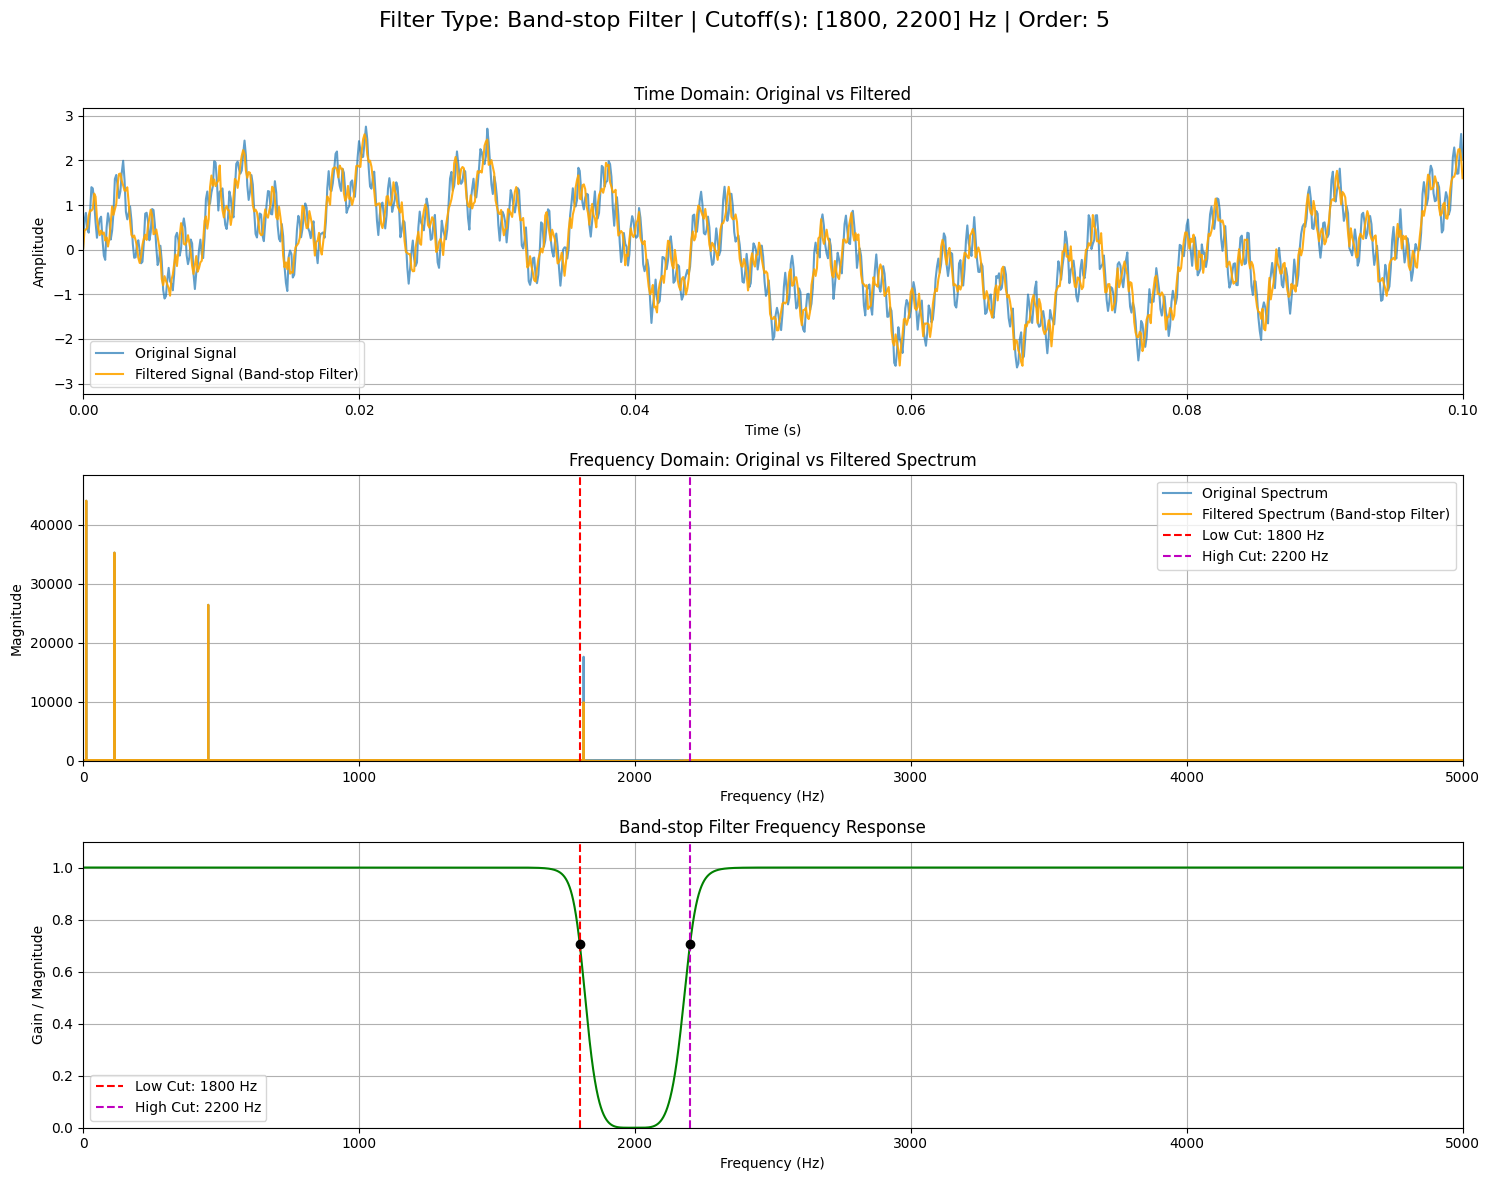

In [204]:
# 3. Band-stop Filter (Notch Filter)
bs_cutoffs = [1800, 2200] # Hz (จะตัดความถี่ระหว่าง 1800-2200 Hz ออก, คือพยายามตัด 2000Hz)
apply_and_plot_filter(original_signal_y, sampling_rate, 'bandstop', bs_cutoffs, filter_order, "Band-stop Filter")

ทำ Short Time Fourier Transform (STFT)

In [205]:
n_fft = 2048 # ขนาดของ FFT window
hop_length = 512 # ระยะการเลื่อนของ window

In [206]:
S = librosa.stft(original_signal_y, n_fft=n_fft, hop_length=hop_length)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

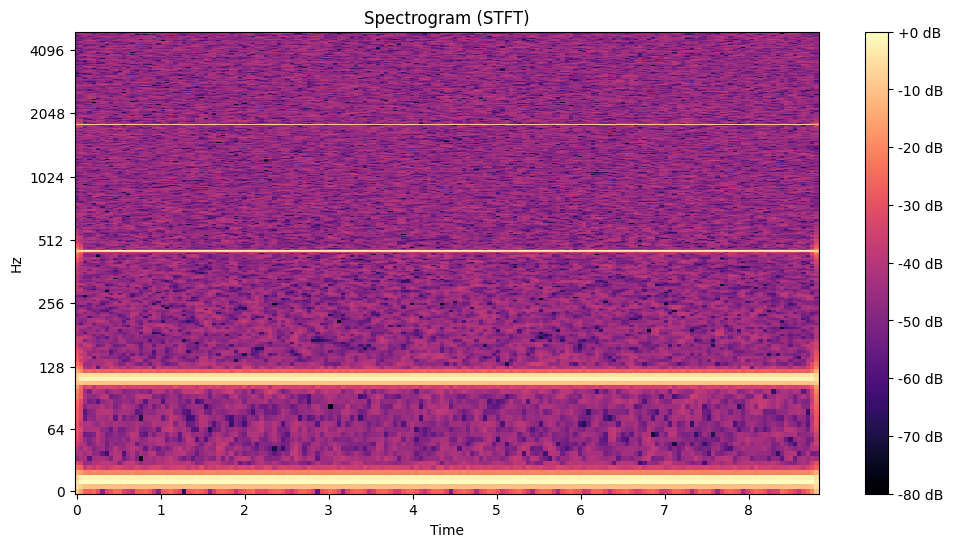

In [207]:
# พล็อต Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(S_db, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='log') # 'log' or 'hz' or 'mel'
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.show()

คำนวณ Chromagram เพื่อดูการกระจายของ pitch

In [208]:
chroma = librosa.feature.chroma_stft(y=original_signal_y, sr=sampling_rate, hop_length=hop_length)

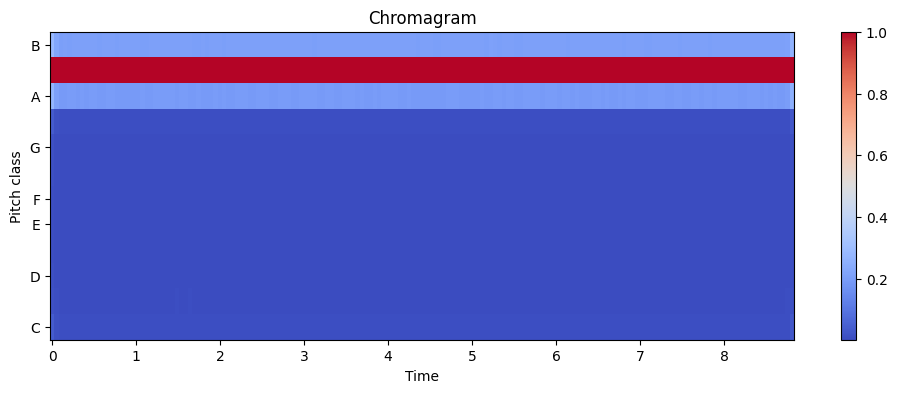

In [209]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(chroma, sr=sampling_rate, hop_length=hop_length, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram')
plt.show()

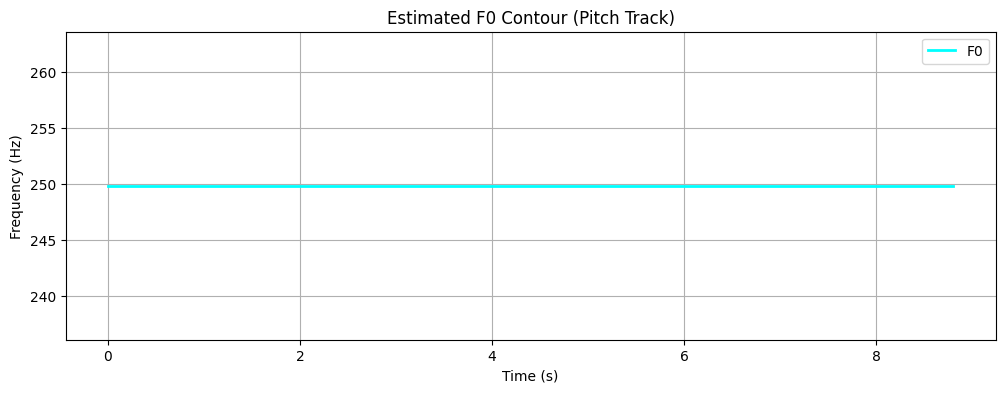

In [210]:
f0, voiced_flag, voiced_probs = librosa.pyin(original_signal_y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sampling_rate)
voiced_f0 = f0.copy()
voiced_f0[~voiced_flag] = np.nan # ตั้งค่า f0 ของ unvoiced frame ให้เป็น NaN เพื่อไม่ให้พล็อต

plt.figure(figsize=(12,4))
plt.plot(times, f0, label='F0', color='cyan', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Estimated F0 Contour (Pitch Track)')
plt.legend()
plt.grid(True)
plt.show()

ทำ Chromagram

> เป็นการแสดงผลในรูปแบบกราฟิกที่แสดงการกระจายของพลังงานเสียงในแต่ละโน้ตดนตรี (pitch class) 12 ตัว (C, C♯/D♭, D, D♯/E♭, E, F, F♯/G♭, G, G♯/A♭, A, A♯/B♭, B)




In [211]:
hop_length_chroma = 512
# chromagram = librosa.feature.chroma_cqt(y=original_signal_y, sr=sampling_rate, hop_length=hop_length_chroma)
y_harmonic, y_percussive = librosa.effects.hpss(original_signal_y)
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sampling_rate, hop_length=hop_length_chroma)

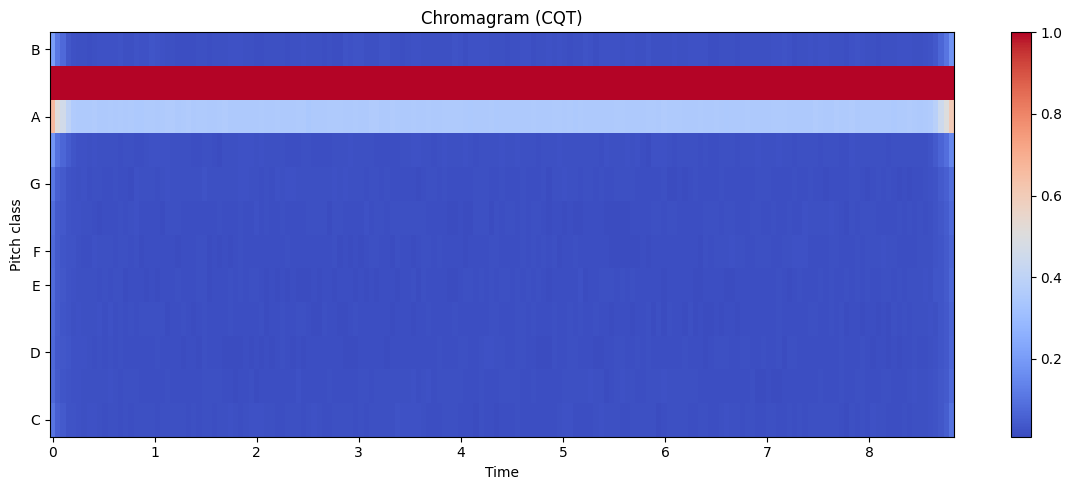

In [212]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(chromagram, sr=sampling_rate, hop_length=hop_length_chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram (CQT)')
plt.tight_layout()
plt.show()

make Pitch Class Profile

In [213]:
pitch_class_profile = np.sum(chromagram, axis=1)
pitch_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [222]:
sorted_pitch_indices = np.argsort(pitch_class_profile)[::-1] # เรียงจากมากไปน้อย
for i, p_name in enumerate(pitch_names):
    print(f"Pitch Class: {p_name:<3} | Raw Energy: {pitch_class_profile[i]:.4f} | Normalized: {normalized_song_profile[i]:.4f}")


Pitch Class: C   | Raw Energy: 3.3605 | Normalized: 0.0126
Pitch Class: C#  | Raw Energy: 3.1052 | Normalized: 0.0116
Pitch Class: D   | Raw Energy: 2.8643 | Normalized: 0.0107
Pitch Class: D#  | Raw Energy: 2.8917 | Normalized: 0.0108
Pitch Class: E   | Raw Energy: 2.9020 | Normalized: 0.0108
Pitch Class: F   | Raw Energy: 2.9494 | Normalized: 0.0110
Pitch Class: F#  | Raw Energy: 3.0360 | Normalized: 0.0113
Pitch Class: G   | Raw Energy: 3.2606 | Normalized: 0.0122
Pitch Class: G#  | Raw Energy: 3.8297 | Normalized: 0.0143
Pitch Class: A   | Raw Energy: 62.2920 | Normalized: 0.2328
Pitch Class: A#  | Raw Energy: 173.0000 | Normalized: 0.6464
Pitch Class: B   | Raw Energy: 4.1353 | Normalized: 0.0155


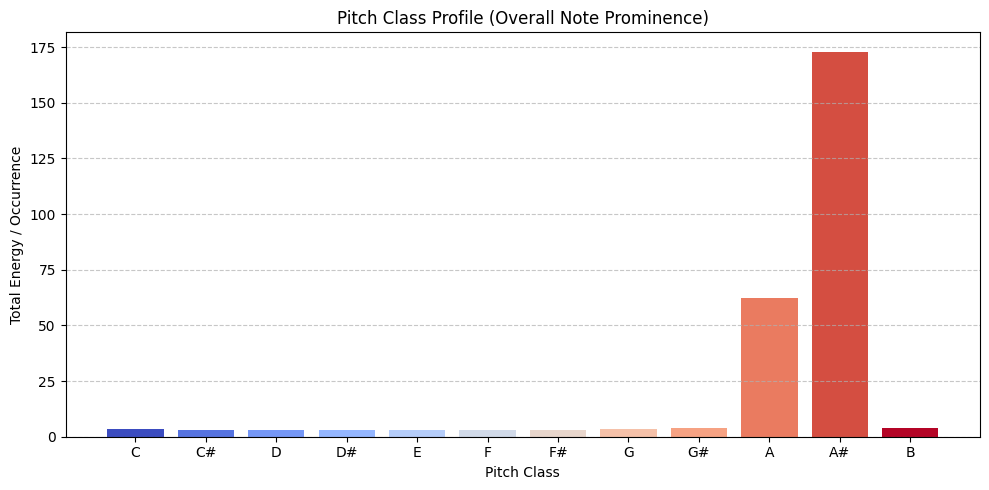

In [223]:
plt.figure(figsize=(10, 5))
plt.bar(pitch_names, pitch_class_profile, color=[plt.cm.coolwarm(x/11.0) for x in range(12)])
plt.title('Pitch Class Profile (Overall Note Prominence)')
plt.xlabel('Pitch Class')
plt.ylabel('Total Energy / Occurrence')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

เทียบ Pitch Class Profile กับ Template ของ Keys

In [216]:
# Major: Root, M2, M3, P4, P5, M6, M7
krumhansl_major_template = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
# Minor (Natural minor): Root, M2, m3, P4, P5, m6, m7
krumhansl_minor_template = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

In [217]:
# Normalize profile ของเพลง
if np.sum(pitch_class_profile) > 0:
    normalized_song_profile = pitch_class_profile / np.sum(pitch_class_profile)
else:
    print("Pitch Class Profile ว่างเปล่า ไม่สามารถวิเคราะห์ Key Signature ได้")
    normalized_song_profile = np.zeros(12) # ให้เป็นศูนย์ถ้า profile ว่าง


In [218]:
key_correlations = []

In [219]:
for i in range(12): # วนสำหรับ root note ทั้ง 12 ตัว
    # Major Key
    shifted_major_template = np.roll(krumhansl_major_template, i)
    if np.std(shifted_major_template) > 0 and np.std(normalized_song_profile) > 0 : # ป้องกัน std dev เป็น 0
        correlation_major = np.corrcoef(normalized_song_profile, shifted_major_template)[0, 1]
    else:
        correlation_major = 0 # หรือ np.nan
    key_correlations.append({'key': f"{pitch_names[i]} Major", 'score': correlation_major, 'type': 'Major'})

    # Minor Key
    shifted_minor_template = np.roll(krumhansl_minor_template, i)
    if np.std(shifted_minor_template) > 0 and np.std(normalized_song_profile) > 0:
        correlation_minor = np.corrcoef(normalized_song_profile, shifted_minor_template)[0, 1]
    else:
        correlation_minor = 0 # หรือ np.nan
    key_correlations.append({'key': f"{pitch_names[i]} minor", 'score': correlation_minor, 'type': 'minor'})


In [220]:
# เรียงลำดับ Key ที่มีความสัมพันธ์ (correlation) สูงสุด
sorted_keys = sorted(key_correlations, key=lambda item: item['score'], reverse=True)

Key Signature ที่มีความเป็นไปได้สูงสุด

In [221]:
if sorted_keys:
    best_guess = sorted_keys[0]
    print(f"\n=> คาดการณ์ Key Signature ที่เป็นไปได้มากที่สุดคือ: {best_guess['key']} (Score: {best_guess['score']:.4f}) 👑")

    # ลองหา relative key ของ best_guess
    best_key_name_parts = best_guess['key'].split()
    root_note_of_best_key = best_key_name_parts[0]
    best_key_type = best_key_name_parts[1]

    # หา index ของ root note
    root_idx = pitch_names.index(root_note_of_best_key)

    if best_key_type == "Major":
        relative_minor_root_idx = (root_idx - 3 + 12) % 12 # Major key -> minor key (ลงไป 3 semitones)
        relative_key_name = f"{pitch_names[relative_minor_root_idx]} minor"
    elif best_key_type == "minor":
        relative_major_root_idx = (root_idx + 3) % 12 # minor key -> Major key (ขึ้นไป 3 semitones)
        relative_key_name = f"{pitch_names[relative_major_root_idx]} Major"
    else:
        relative_key_name = None

    if relative_key_name:
        # หา score ของ relative key จาก sorted_keys
        relative_key_score = None
        for item in sorted_keys:
            if item['key'] == relative_key_name:
                relative_key_score = item['score']
                break
        if relative_key_score is not None:
            print(f"   Relative key ที่เกี่ยวข้อง: {relative_key_name} (Score: {relative_key_score:.4f})")
        else:
            print(f"   ไม่พบ Relative key ({relative_key_name}) ในการจัดอันดับ")

else:
    print("\nไม่สามารถคาดการณ์ Key Signature ได้")


=> คาดการณ์ Key Signature ที่เป็นไปได้มากที่สุดคือ: A# minor (Score: 0.6163) 👑
   Relative key ที่เกี่ยวข้อง: C# Major (Score: -0.0471)
